In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('CartPole-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        self.step_n += 1
        if self.step_n >= 200:
            done = True
        return state, reward, done, info


env = MyWrapper()

env.reset()

array([ 0.03780822, -0.02429027,  0.02112488, -0.02773819], dtype=float32)

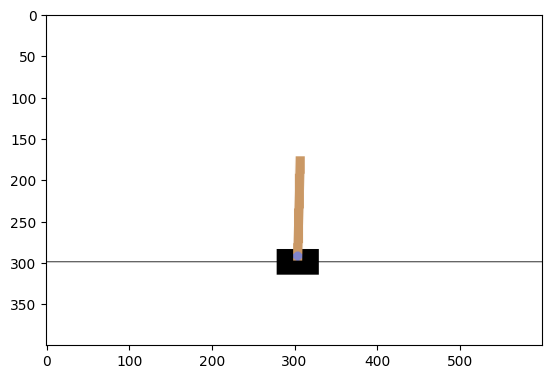

In [2]:
from matplotlib import pyplot as plt

%matplotlib inline


#打印游戏
def show():
    plt.imshow(env.render())
    plt.show()


show()

In [3]:
import torch
import random


class ModelAction(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
                    torch.nn.Linear(4, 128),
                    torch.nn.ReLU(),
                    torch.nn.Linear(128, 2),
                    torch.nn.Softmax(dim=1),
                )

    def forward(self, state):
        prob = self.model(state)  

        # 采样动作
        action = [random.choices(range(2), weights=p.tolist(), k=1)[0] for p in prob]  # 采样一个动作

        # 计算熵
        # prob[0, action] 是采样动作 action 的概率
        #log_prob = torch.log(prob + 1e-7)  # 避免 log(0) 加小 epsilon
        #entropy = -log_prob  # 单个动作的熵贡献，-log π(a|s)

        # 改2：离散熵用求和
        #[b, 2]
        entropy = prob * torch.log(prob + 1e-8)

        #所有动作的熵求和
        #[b, 2] -> [b, 1]
        entropy = -entropy.sum(dim=1, keepdim=True)
        # 或者更准确的熵估计（基于整个分布）
        # 熵 = -∑ π(a|s) log π(a|s)，可以使用 prob 直接计算期望
        #entropy = -torch.sum(prob * torch.log(prob + 1e-7))  # 整个分布的熵

        return action, entropy.reshape(-1,1), prob


model_action = ModelAction()

model_action(torch.randn(2,4))

([1, 1],
 tensor([[0.6790],
         [0.6861]], grad_fn=<ViewBackward0>),
 tensor([[0.4162, 0.5838],
         [0.4408, 0.5592]], grad_fn=<SoftmaxBackward0>))

In [4]:
class ModelValue(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(5, 128),
            torch.nn.ReLU(),#改9：删去一层
            # 改4：输出是二维以匹配后面的与prob相乘
            torch.nn.Linear(128, 2),
        )

    def forward(self, state, action):
        #[b, 4+1] -> [b, 5]
        state = torch.cat([state, action], dim=1)

        #[b, 5] -> [b, 1]
        return self.sequential(state)


model_value1 = ModelValue()
model_value2 = ModelValue()

model_value_next1 = ModelValue()
model_value_next2 = ModelValue()

model_value_next1.load_state_dict(model_value1.state_dict())
model_value_next2.load_state_dict(model_value2.state_dict())

model_value1(torch.randn(2, 4), torch.randn(2, 1))

tensor([[ 0.2539, -0.0166],
        [ 0.2044, -0.1752]], grad_fn=<AddmmBackward0>)

In [5]:
import numpy as np


def get_action(state):
    state = torch.FloatTensor(state).reshape(1, 4)
    #[1, 4] -> [1, 2]
    action, _, __ = model_action(state)

    return action


get_action([1, 2, 3, 4])

[1]

In [6]:
#样本池
datas = []


### 改1：要收集足够多的数据
#向样本池中添加N条数据,删除M条最古老的数据
def update_data():
    old_count = len(datas)

    #玩到新增了N个数据为止
    while len(datas) - old_count < 200:
        #初始化游戏
        state = env.reset()

        #玩到游戏结束为止
        over = False
        while not over:
            #根据当前状态得到一个动作
            action = get_action(state)

            #执行动作,得到反馈
            next_state, reward, over, _ = env.step(action[0])

            #记录数据样本
            datas.append((state, action, reward, next_state, over))

            #更新游戏状态,开始下一个动作
            state = next_state

    update_count = len(datas) - old_count
    drop_count = max(len(datas) - 10000, 0)

    #数据上限,超出时从最古老的开始删除
    while len(datas) > 10000:
        datas.pop(0)

    return update_count, drop_count


update_data(), len(datas)

/home/yuchen/Fdisk/miniconda3/envs/RL-py39/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


((202, 0), 202)

In [7]:
#获取一批数据样本
def get_sample():
    #从样本池中采样
    samples = random.sample(datas, 64)

    # 改8： 返回数据类型 action F->L reward:L->F
    #[b, 4]
    state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 4)
    #[b, 1]
    action = torch.LongTensor([i[1] for i in samples]).reshape(-1, 1)
    #[b, 1]
    reward = torch.FloatTensor([i[2] for i in samples]).reshape(-1, 1)
    #[b, 4]
    next_state = torch.FloatTensor([i[3] for i in samples]).reshape(-1, 4)
    #[b, 1]
    over = torch.LongTensor([i[4] for i in samples]).reshape(-1, 1)

    return state, action, reward, next_state, over


state, action, reward, next_state, over = get_sample()

state[:5], action[:5], reward[:5], next_state[:5], over[:5]

/tmp/ipykernel_460657/3749404182.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 4)


(tensor([[ 0.1012,  0.0047, -0.1413, -0.4497],
         [-0.1541, -0.7941,  0.2055,  1.4614],
         [-0.0629,  0.1687,  0.1089, -0.1926],
         [-0.0017, -0.3617,  0.0326,  0.6079],
         [ 0.0991,  0.3741, -0.0797, -0.5738]]),
 tensor([[1],
         [0],
         [0],
         [0],
         [0]]),
 tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.]]),
 tensor([[ 0.1013,  0.2015, -0.1503, -0.7834],
         [-0.1700, -0.9911,  0.2347,  1.8106],
         [-0.0595, -0.0278,  0.1051,  0.1324],
         [-0.0089, -0.5573,  0.0448,  0.9107],
         [ 0.1066,  0.1802, -0.0912, -0.3073]]),
 tensor([[0],
         [1],
         [0],
         [0],
         [0]]))

In [8]:
from IPython import display


def test(play):
    #初始化游戏
    state = env.reset()

    #记录反馈值的和,这个值越大越好
    reward_sum = 0

    #玩到游戏结束为止
    over = False
    while not over:
        #根据当前状态得到一个动作
        action = get_action(state)

        #执行动作,得到反馈
        state, reward, over, _ = env.step(action[0])
        reward_sum += reward

        #打印动画
        if play and random.random() < 0.2:  #跳帧
            display.clear_output(wait=True)
            show()

    return reward_sum


test(play=False)

35.0

In [9]:
def soft_update(model, model_next):
    for param, param_next in zip(model.parameters(), model_next.parameters()):
        #以一个小的比例更新
        value = param_next.data * 0.995 + param.data * 0.005
        param_next.data.copy_(value)


soft_update(torch.nn.Linear(4, 64), torch.nn.Linear(4, 64))

In [10]:
import math

#这也是一个可学习的参数
alpha = torch.tensor(math.log(0.01))
alpha.requires_grad = True

alpha

tensor(-4.6052, requires_grad=True)

In [11]:
def get_target(reward, next_state, over):
    #首先使用model_action计算动作和动作的熵
    #[b, 4] -> [b, 1],[b, 1]
    action, entropy, prob= model_action(next_state)

    #评估next_state的价值
    #[b, 4],[b, 1] -> [b, 1]
    action_tensor = torch.tensor(action, dtype=torch.float32).reshape(-1,1)
    target1 = model_value_next1(next_state, action_tensor)
    target2 = model_value_next2(next_state, action_tensor)

    #取价值小的,这是出于稳定性考虑
    #[b, 1]
    target = torch.min(target1, target2)

    # 改5：二维的value和prob结合求其期望
    target = (prob * target)
    target = target.sum(dim=1, keepdim=True)

    #exp和log互为反操作,这里是把alpha还原了
    #这里的操作是在target上加上了动作的熵,alpha作为权重系数
    #[b, 1] - [b, 1] -> [b, 1]
    target += alpha.exp() * entropy

    #[b, 1]
    target *= 0.99
    target *= (1 - over)
    target += reward

    return target


get_target(reward, next_state, over).shape

torch.Size([64, 1])

In [12]:
def get_loss_action(state):
    #计算action和熵
    #[b, 4] -> [b, 1],[b, 1]
    action, entropy, prob = model_action(state)

    #使用两个value网络评估action的价值
    #[b, 4],[b, 1] -> [b, 1]
    action_tensor = torch.tensor(action, dtype=torch.float32).reshape(-1,1)
    value1 = model_value1(state, action_tensor)
    value2 = model_value2(state, action_tensor)

    #取价值小的,出于稳定性考虑
    #[b, 1]
    value = torch.min(value1, value2)

    #alpha还原后乘以熵,这个值期望的是越大越好,但是这里是计算loss,所以符号取反
    #[1] - [b, 1] -> [b, 1]
    loss_action = -alpha.exp() * entropy

    # 改3：熵求和后变为1x1的了，value也要加权求和
    #按概率对value进行加权
    value *= prob
    value = value.sum(dim=1, keepdim=True)
    #减去value,所以value越大越好,这样loss就会越小
    loss_action -= value #图片公式里用了V，这里没用到

    return loss_action.mean(), entropy


get_loss_action(state)

(tensor(0.0591, grad_fn=<MeanBackward0>),
 tensor([[0.6865],
         [0.6921],
         [0.6867],
         [0.6893],
         [0.6873],
         [0.6861],
         [0.6884],
         [0.6876],
         [0.6862],
         [0.6881],
         [0.6856],
         [0.6869],
         [0.6866],
         [0.6886],
         [0.6898],
         [0.6876],
         [0.6869],
         [0.6870],
         [0.6833],
         [0.6863],
         [0.6884],
         [0.6866],
         [0.6850],
         [0.6895],
         [0.6867],
         [0.6920],
         [0.6861],
         [0.6861],
         [0.6877],
         [0.6856],
         [0.6902],
         [0.6902],
         [0.6866],
         [0.6870],
         [0.6883],
         [0.6872],
         [0.6871],
         [0.6921],
         [0.6869],
         [0.6867],
         [0.6888],
         [0.6864],
         [0.6865],
         [0.6888],
         [0.6898],
         [0.6868],
         [0.6876],
         [0.6877],
         [0.6856],
         [0.6897],
        

In [13]:
def train():
    #改7： 学习率大小
    optimizer_action = torch.optim.Adam(model_action.parameters(), lr=1e-3)
    optimizer_value1 = torch.optim.Adam(model_value1.parameters(), lr=1e-2)
    optimizer_value2 = torch.optim.Adam(model_value2.parameters(), lr=1e-2)

    #alpha也是要更新的参数,所以这里要定义优化器
    optimizer_alpha = torch.optim.Adam([alpha], lr=1e-2)

    loss_fn = torch.nn.MSELoss()

    #训练N次
    for epoch in range(100):
        #更新N条数据
        update_data()

        #每次更新过数据后,学习N次
        for i in range(200):
            #采样一批数据
            state, action, reward, next_state, over = get_sample()

            #对reward偏移,为了便于训练
            reward = (reward + 8) / 8

            #计算target,这个target里已经考虑了动作的熵
            #[b, 1]
            target = get_target(reward, next_state, over)
            target = target.detach()

            # 改6：取对应动作的value值 [b,2]->[b,1]
            #计算两个value
            value1 = model_value1(state, action).gather(dim=1, index=action.to(torch.int64))
            value2 = model_value2(state, action).gather(dim=1, index=action.to(torch.int64))

            #计算两个loss,两个value的目标都是要贴近target
            loss_value1 = loss_fn(value1, target)
            loss_value2 = loss_fn(value2, target)

            #更新参数
            optimizer_value1.zero_grad()
            loss_value1.backward()
            optimizer_value1.step()

            optimizer_value2.zero_grad()
            loss_value2.backward()
            optimizer_value2.step()

            #使用model_value计算model_action的loss
            loss_action, entropy = get_loss_action(state)
            optimizer_action.zero_grad()
            loss_action.backward()
            optimizer_action.step()

            #熵乘以alpha就是alpha的loss
            #[b, 1] -> [1]
            loss_alpha = (entropy + 1).detach() * alpha.exp()
            loss_alpha = loss_alpha.mean()

            #更新alpha值
            optimizer_alpha.zero_grad()
            loss_alpha.backward()
            optimizer_alpha.step()

            #增量更新next模型
            soft_update(model_value1, model_value_next1)
            soft_update(model_value2, model_value_next2)

        if epoch % 10 == 0:
            test_result = sum([test(play=False) for _ in range(10)]) / 10
            print(epoch, len(datas), alpha.exp().item(), test_result)


train()

0 406 0.0028979189228266478 9.4
10 2450 0.00011433335748733953 9.0


KeyboardInterrupt: 

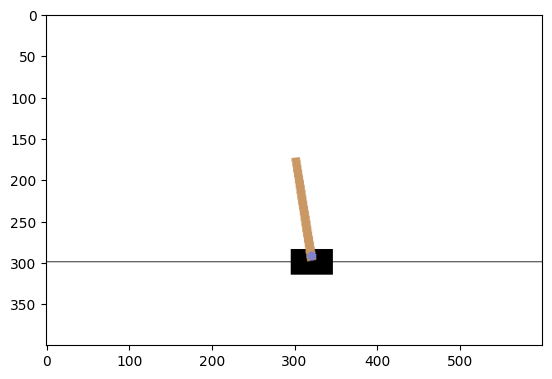

10.0

In [15]:
test(play=True)